In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

In [2]:
import tensorflow 

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model,Sequential

In [4]:
x="Hi hello how are you"
print(len(x.split()))

5


In [5]:
import nltk
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords=stopwords.words("english")
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


In [6]:
url="https://raw.githubusercontent.com/Sooryak12/FakeReviewDetectionLSTM/master/selected.txt"


In [7]:
df=pd.read_csv(url,delimiter="\t")
df.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


In [8]:
df.isnull().sum()

DOC_ID               0
LABEL                0
RATING               0
VERIFIED_PURCHASE    0
PRODUCT_CATEGORY     0
PRODUCT_ID           0
PRODUCT_TITLE        0
REVIEW_TITLE         0
REVIEW_TEXT          0
dtype: int64

In [9]:
df["PRODUCT_CATEGORY"].value_counts()

Musical Instruments       700
Luggage                   700
Video Games               700
Toys                      700
Home Entertainment        700
Beauty                    700
Health & Personal Care    700
Furniture                 700
Automotive                700
Sports                    700
Pet Products              700
Home Improvement          700
Jewelry                   700
Books                     700
Grocery                   700
Shoes                     700
Tools                     700
Home                      700
Video DVD                 700
Watches                   700
Kitchen                   700
Outdoors                  700
PC                        700
Lawn and Garden           700
Baby                      700
Camera                    700
Wireless                  700
Office Products           700
Apparel                   700
Electronics               700
Name: PRODUCT_CATEGORY, dtype: int64

In [10]:
df["LABEL"]=df["LABEL"].replace(['__label2__','__label1__'],['0','1'])

In [11]:
dfs=df[["REVIEW_TEXT","LABEL","PRODUCT_CATEGORY"]]
dfs = dfs.rename(columns={'REVIEW_TEXT': 'reviews',"LABEL":"label","PRODUCT_CATEGORY":"cat"})

In [12]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  21000 non-null  object
 1   label    21000 non-null  object
 2   cat      21000 non-null  object
dtypes: object(3)
memory usage: 492.3+ KB


In [13]:
dfs["reviews"]=dfs["reviews"].apply(lambda x:x.lower())
dfs["reviews"] = dfs["reviews"].apply(lambda x: re.sub("[^a-zA-Z]", " ", x))
dfs["reviews"] = dfs["reviews"].apply(lambda x: re.sub("\s+", " ", x))

In [14]:
dfs["label"].value_counts()

1    10500
0    10500
Name: label, dtype: int64

The Data is Unbiased

In [15]:
dfs.head()

,reviews,label,cat
0,when least you think so this product will save...,1,PC
1,lithium batteries are something new introduced...,1,Wireless
2,i purchased this swing for my baby she is mont...,1,Baby
3,i was looking for an inexpensive desk calcolat...,1,Office Products
4,i only use it twice a week and the results are...,1,Beauty


In [16]:
"not" in stopwords

True

In [17]:
#nltk.download('punkt')
def stop(text):
    clean_sent =[]
    for w in word_tokenize(text):
        if not w in stopwords:
            clean_sent.append(w)
    return (" ".join(clean_sent))

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):

    word_tokens = nltk.word_tokenize(text)
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in word_tokens]
    return (" ".join(lemmatized_word))


In [18]:
#dfs["reviews"]=dfs["reviews"].apply(lemmatize)
dfs["reviews"]=dfs["reviews"].apply(stop)

In [19]:
dfs["reviews"][10]

'unfortunately work made sick throw two times tried'

In [20]:
dfs["length"]=dfs["reviews"].apply(lambda x: len(x.split()))

In [21]:
dfs["length"].head()

0    10
1    40
2    19
3    19
4    27
Name: length, dtype: int64

In [22]:
dfs["reviews"][0]

'least think product save day keep around case need something'

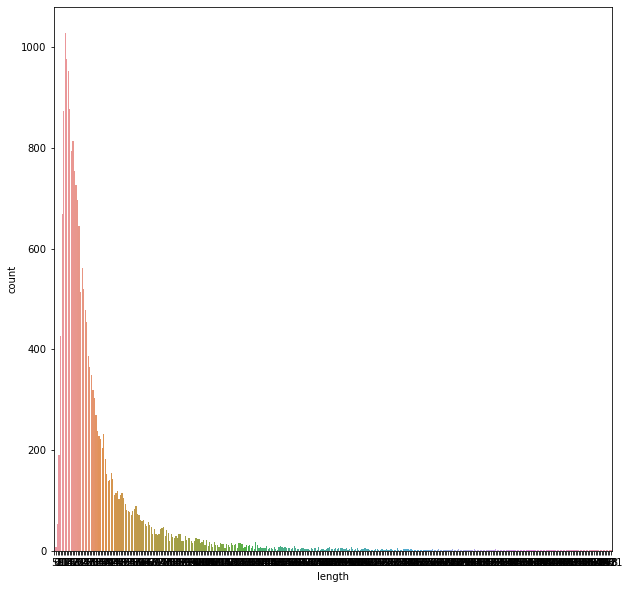

In [23]:
plt.figure(figsize=(10,10))
sns.countplot(dfs["length"])
plt.show()

In [24]:
np.mean(dfs["length"])

34.400285714285715

We see that there are many outliers and the data is heavily left skewed.So we have to do much more analysis to select the proper lenth for the text to embedd.

In [25]:
txt=" mean:{} \n median:{} \n maximum length:{} \n minimum length:{}".format(np.mean(dfs["length"]),np.median(dfs["length"]),np.max(dfs["length"]),np.min(dfs["length"]))

In [26]:
print(txt)

 mean:34.400285714285715 
 median:22.0 
 maximum length:1421 
 minimum length:5


In [27]:
def category(x):
    if 0<x<11:
        return 5
    elif 10<x<21:
        return 15
    elif 20<x<31:
        return 25
    elif 30<x<41:
        return 35
    elif 40<x<50:
        return 45
    elif 50<x<61:
        return 55
    elif 60<x<101:
        return 80
    elif 100<x<301:
        return 150
    elif 300<x<601:
        return 450
    elif 600<x<1001:
        return 800
    elif 1000<x<1501:
        return 1250
    

In [28]:
dfs["textcat"]=dfs["length"].apply(category)

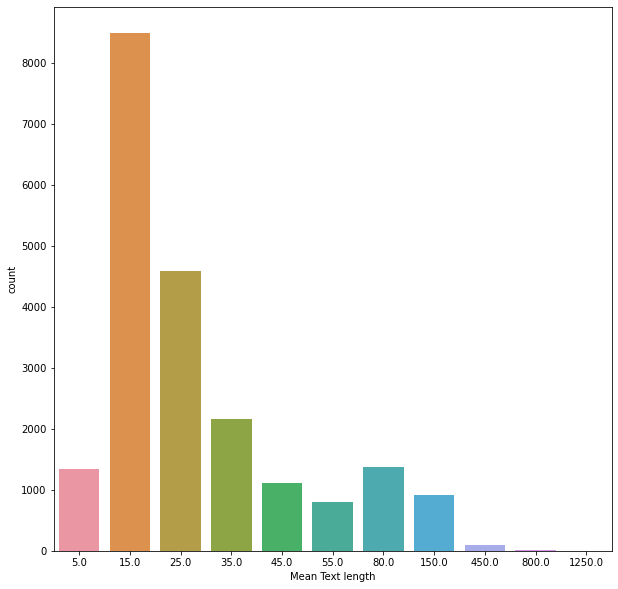

In [29]:
plt.figure(figsize=(10,10))
ax=sns.countplot(dfs["textcat"])
ax.set(xlabel="Mean Text length")
plt.show()

In [30]:
(15+25+35)/3

25.0

Ideal Text size will be of 30-40

In [31]:
c=0
for i in dfs["length"]:
    if 700<i:
      c+=1
print(c)

7


Texts with text size >700 is just 7 .We can remove them.
The above mentioned values are the index of outliers.

In [32]:
c=0
for i in dfs["length"]:
    if 40>i>1:
      c+=1
print(c)

16463


In [33]:
len(dfs["length"])

21000

In [34]:
19921/21000

0.9486190476190476

In [35]:
16321/21000

0.7771904761904762

In [36]:
19030/21000

0.9061904761904762

90% of the data lies with text size between 1 and 70.So we can remove all the other data.
77% of the data lies with text size between 40.As LSTM takes long time to train .This data is enough i guess.

In [37]:
dfs.columns

Index(['reviews', 'label', 'cat', 'length', 'textcat'], dtype='object')

In [38]:
dfs.head()

,reviews,label,cat,length,textcat
0,least think product save day keep around case ...,1,PC,10,5.0
1,lithium batteries something new introduced mar...,1,Wireless,40,35.0
2,purchased swing baby months pretty much grown ...,1,Baby,19,15.0
3,looking inexpensive desk calcolatur works ever...,1,Office Products,19,15.0
4,use twice week results great used teeth whiten...,1,Beauty,27,25.0


In [39]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   reviews  21000 non-null  object 
 1   label    21000 non-null  object 
 2   cat      21000 non-null  object 
 3   length   21000 non-null  int64  
 4   textcat  20896 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 820.4+ KB


In [40]:
dfs=dfs[dfs["length"]<41]
dfs.reset_index(drop=True,inplace=True)

In [41]:
dfs.iloc[13]

reviews    bought brown island hydraulic mechanism looks ...
label                                                      1
cat                                                Furniture
length                                                    27
textcat                                                   25
Name: 13, dtype: object

In [42]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16601 entries, 0 to 16600
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   reviews  16601 non-null  object 
 1   label    16601 non-null  object 
 2   cat      16601 non-null  object 
 3   length   16601 non-null  int64  
 4   textcat  16601 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 648.6+ KB


In [43]:
dfs["label"]=dfs["label"].astype(np.float32)

we removed the outlier texts.

In [44]:
dfs["cat"].value_counts()

Jewelry                   652
Shoes                     636
Apparel                   626
Watches                   603
Office Products           590
Furniture                 585
Automotive                577
Home                      576
Wireless                  571
Musical Instruments       567
Outdoors                  563
Sports                    559
Tools                     557
Toys                      554
Lawn and Garden           551
Luggage                   550
Health & Personal Care    549
Beauty                    543
Home Improvement          542
Baby                      540
Grocery                   538
Pet Products              537
Video Games               536
Electronics               532
PC                        530
Kitchen                   525
Video DVD                 515
Camera                    511
Home Entertainment        463
Books                     423
Name: cat, dtype: int64

In [45]:
dfs["label"].value_counts()

1.0    8882
0.0    7719
Name: label, dtype: int64

In [46]:
dfs["reviews"][0]

'least think product save day keep around case need something'

In [47]:
test_dfs=dfs

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
embeddings_index = dict()
f = open('glove.6B.100d.txt',encoding='utf8')

In [50]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [51]:
df_train,df_test,Ytrain,Ytest = train_test_split(dfs["reviews"],dfs["label"], test_size=0.2, random_state=101)

In [52]:
MAX_VOCAB_SIZE=30000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,oov_token="<OOV>")
tokenizer.fit_on_texts(df_train)

In [53]:
word2idx=tokenizer.word_index
len(word2idx)

17890

In [54]:
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [55]:
data_train = pad_sequences(sequences_train,maxlen=40)
print('Shape of data train tensor:',data_train.shape)
T = data_train.shape[1]

Shape of data train tensor: (13280, 40)


In [56]:
data_test = pad_sequences(sequences_test,maxlen=T)
print('Shape of data test tensor:',data_test.shape)

Shape of data test tensor: (3321, 40)


In [57]:
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, 100))
for word, index in tokenizer.word_index.items():
    if index > MAX_VOCAB_SIZE - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [58]:
from tensorflow.keras.layers import Dropout,Conv1D,MaxPooling1D

In [59]:
model_glove = Sequential()
model_glove.add(Embedding(MAX_VOCAB_SIZE, 100, input_length=40, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))


In [60]:
model_glove.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
r=model_glove.fit(data_train, np.array(Ytrain), validation_data=(data_test,Ytest), epochs = 10)

NameError: name 'tf' is not defined

In [ ]:
plt.plot(r.history["accuracy"],label="accuracy")
plt.plot(r.history["val_accuracy"],label="val_accuracy")
plt.legend()

In [63]:
import tensorflow as tf

In [64]:
#Model 2
model_glove = Sequential()
model_glove.add(Embedding(MAX_VOCAB_SIZE, 100, input_length=40, weights=[embedding_matrix], trainable=True))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
r=model_glove.fit(data_train, np.array(Ytrain), validation_data=(data_test,Ytest), epochs = 10)

Train on 13280 samples, validate on 3321 samples
Epoch 1/10
13280/13280 [==============================] - 40s 3ms/sample - loss: 0.6785 - accuracy: 0.5269 - val_loss: 0.6615 - val_accuracy: 0.5863
Epoch 2/10
13280/13280 [==============================] - 33s 2ms/sample - loss: 0.6505 - accuracy: 0.6254 - val_loss: 0.6557 - val_accuracy: 0.5902
Epoch 3/10
13280/13280 [==============================] - 33s 3ms/sample - loss: 0.6313 - accuracy: 0.6724 - val_loss: 0.6753 - val_accuracy: 0.6170
Epoch 4/10
13280/13280 [==============================] - 34s 3ms/sample - loss: 0.6134 - accuracy: 0.7177 - val_loss: 0.6620 - val_accuracy: 0.6260
Epoch 5/10
13280/13280 [==============================] - 35s 3ms/sample - loss: 0.5993 - accuracy: 0.7496 - val_loss: 0.6578 - val_accuracy: 0.6155
Epoch 6/10
13280/13280 [==============================] - 35s 3ms/sample - loss: 0.5883 - accuracy: 0.7753 - val_loss: 0.6609 - val_accuracy: 0.6167
Epoch 7/10
13280/13280 [==============================] -

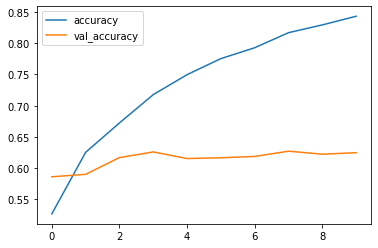

In [65]:
plt.plot(r.history["accuracy"],label="accuracy")
plt.plot(r.history["val_accuracy"],label="val_accuracy")
plt.legend()

In [66]:
from sklearn.manifold import TSNE
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [68]:
"""
glove_embds = model_glove.layers[0].get_weights()[0]

def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data_train[start:stop:step,0], 
        y = data_train[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)

glove_tsne_embds = TSNE(n_components=2).fit_transform(glove_embds)
plot_words(glove_tsne_embds, 0, 2000, 1)
"""
#Taking alot of time.

KeyboardInterrupt: 

In [ ]:
#Model 3
model3=tf.keras.Sequential([
tf.keras.layers.Embedding(MAX_VOCAB_SIZE+1,100,input_length=40,weights=[embedding_matrix],trainable=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64,activation="relu"),
tf.keras.layers.Dense(1,activation="sigmoid")])

In [ ]:
model3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
r=model3.fit(data_train, np.array(Ytrain), validation_data=(data_test,Ytest), epochs = 10,batch_size=64)

In [ ]:
embedding_matrix